# 5.6 Assignment 5: Clustering
With the accidents involving Boeing's 737 Max, there have been speculations and concerns about airline safety. Then, there was a helicopter crash involving Kobe Bryant. Academic studies have found that high-profile crashes can shift passenger demand away from the airlines involved in the disasters.<p>

Should travelers avoid airlines that have had crashes in the past? That is the question we will try to address in this exercise. The dataset for this has been sourced from Aviation Safety Network.<p>
Step 1: Use this dataset and two different clustering approaches (agglomerative and divisive) to group the airlines with similar safety records.<p>

Step 2: Do these two approaches lead to the same/similar results? Provide appropriate visualizations, clustering summaries, and your interpretations.<p>

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
%run ../setup_uw.ipynb

make_jupyter_cells_wide()


In [6]:
df_airline = pd.read_csv('airline-safety.csv')
print(df_airline.columns)
display(df_airline.head(3))

Index(['airline', 'avail_seat_km_per_week', 'incidents_85_99',
       'fatal_accidents_85_99', 'fatalities_85_99', 'incidents_00_14',
       'fatal_accidents_00_14', 'fatalities_00_14'],
      dtype='object')


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0


In [7]:
df = df_airline.copy()
df['airline'] = df['airline'].str.replace('*', '', regex=False)
df['airline'] = df['airline'].str.replace(' / ', '/', regex=False)
df.set_index('airline')
df.head(3)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0


In [8]:
cluster_types = ['Agglomerative', 'Divisive K-Means']
results = {}
features_all = ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99',
                'incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']
features_pre = features_all[:3]
features_post = features_all[3:]
features_eras = ['pre', 'post', 'all']
def get_feat(era='all'):
    if era == 'all':
        return features_all
    if era == 'pre':
        return features_pre
    if era == 'post':
        return features_post

# Step 1: Agglomerative

raw Step 1a: 5 Cluster Agglomerative Cluster with incidents/fatalities from 1985-1989
cluster_5


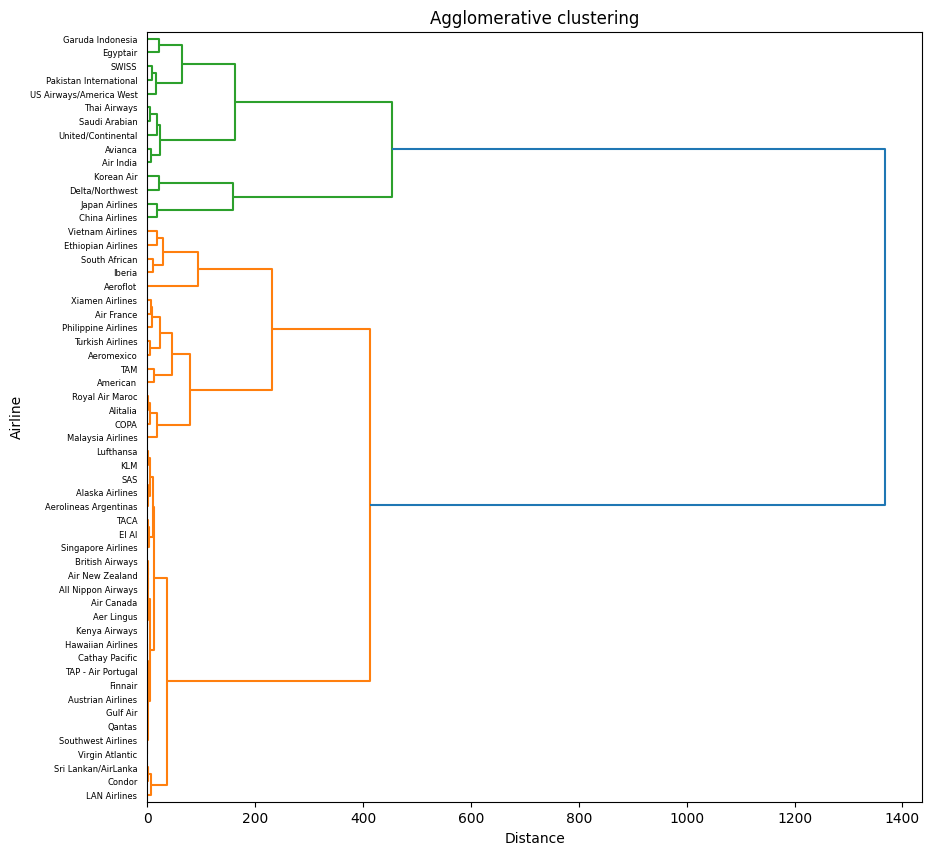

Silhouette Score for Agglomerative Clustering: 0.6989808140014081


In [9]:
step = 'Step 1a'
n_clusters = 5
cluster_type = 'Agglomerative'
scale = 'raw'
features_era = 'pre'
features = get_feat(features_era)
cluster_col = f'cluster_{n_clusters}'
print(f"{scale} {step}: {n_clusters} Cluster {cluster_type} Cluster with incidents/fatalities from 1985-1989")
print(cluster_col)
X = df[features]
# Perform hierarchical clustering
Z = sch.linkage(X, method='ward')

# Perform Agglomerative Clustering with 5 clusters
ac = AgglomerativeClustering(n_clusters=5)
y_ac = ac.fit_predict(X)
# Add the cluster assignments back to the DataFrame
df[cluster_col] = y_ac

# Plot dendrogram
plt.figure(figsize=(10, 10))
plt.title('Agglomerative clustering')
sch.dendrogram(Z, orientation='right', labels=df['airline'].tolist())
plt.xlabel('Distance')
plt.ylabel('Airline')
plt.show()

# Calculate silhouette score
a_silhouette = silhouette_score(X, y_ac)
print(f"Silhouette Score for Agglomerative Clustering: {a_silhouette}")
results[step] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col,   
                 'silhouette_score': float(a_silhouette), 'inertia': None, 'features_era': features_era, 'features': features}

In [10]:
# Analyze fatalities per cluster with 5 clusters
step = 'Step 1b'
features_era = 'pre'
features = get_feat(features_era)
print(f"{step}: {n_clusters} Cluster {cluster_type} Analysis with incidents/fatalities from 1985-1989")
print(cluster_col)
cluster_analysis = df.groupby(cluster_col)['fatalities_85_99'].agg(['mean', 'median', 'max'])
print("\nFatalities (1985-1999) per Cluster:")
print(cluster_analysis.sort_values(by='max', ascending=False))

# Identify airlines in the clusters with highest and lowest max fatalities
worst_cluster = cluster_analysis['max'].idxmax()
best_cluster = cluster_analysis['max'].idxmin()

worst_airlines = df[df[cluster_col] == worst_cluster].index.tolist()
best_airlines = df[df[cluster_col] == best_cluster].index.tolist()

print(f"\nAirlines in the cluster with the highest max fatalities (Cluster {worst_cluster}):")
for idx in worst_airlines:
    airline = df['airline'].iloc[idx]
    print(f"- {airline}")

print(f"\nAirlines in the cluster with the lowest max fatalities (Cluster {best_cluster}):")
for idx in best_airlines:
    airline = df['airline'].iloc[idx]
    print(f"- {airline}")
    
# Get the airlines in the worst cluster and sort by fatalities
worst_cluster_df = df[df[cluster_col] == worst_cluster].sort_values(by='fatalities_85_99', ascending=False)
print(f"\nTop 5 Airlines in the cluster with the worst safety record (Cluster {worst_cluster}):")
for idx, row in worst_cluster_df.head(5).iterrows():
    airline = df['airline'].iloc[idx]
    print(f"- {airline} fatalities 1985-1999: {row['fatalities_85_99']:,.0f}")

# Get the airlines in the best cluster and sort by fatalities (ascending)
best_cluster_df = df[df[cluster_col] == best_cluster].sort_values(by='fatalities_85_99', ascending=True)
print(f"\nTop 5 Airlines in the cluster with the best safety record (Cluster {best_cluster}):")
for idx, row in best_cluster_df.head(5).iterrows():
    airline = df['airline'].iloc[idx]
    print(f"- {airline} fatalities 1985-1999: {row['fatalities_85_99']:,.0f}")

Step 1b: 5 Cluster Agglomerative Analysis with incidents/fatalities from 1985-1989
cluster_5

Fatalities (1985-1999) per Cluster:
                 mean  median  max
cluster_5                         
2          471.750000   472.5  535
0          282.100000   295.0  329
1          154.600000   159.0  171
4           67.636364    64.0  101
3            2.692308     0.0   21

Airlines in the cluster with the highest max fatalities (Cluster 2):
- China Airlines
- Delta/Northwest
- Japan Airlines
- Korean Air

Airlines in the cluster with the lowest max fatalities (Cluster 3):
- Aer Lingus
- Aerolineas Argentinas
- Air Canada
- Air New Zealand
- Alaska Airlines
- All Nippon Airways
- Austrian Airlines
- British Airways
- Cathay Pacific
- Condor
- El Al
- Finnair
- Gulf Air
- Hawaiian Airlines
- Kenya Airways
- KLM
- LAN Airlines
- Lufthansa
- Qantas
- SAS
- Singapore Airlines
- Southwest Airlines
- Sri Lankan/AirLanka
- TACA
- TAP - Air Portugal
- Virgin Atlantic

Top 5 Airlines in the clus

In [11]:
step = 'Step 1c'
n_clusters = 2
cluster_type = 'Agglomerative'
features_era = 'pre'
features = get_feat(features_era)
cluster_col = f'cluster_{n_clusters}'
print(f"{step}: {n_clusters} Cluster {cluster_type} Cluster with incidents/fatalities from 1985-1989")
print(cluster_col)
print("{n_clusters} Cluster Agglomerative Analysis incidents/fatalities from 1985-1989")
# Analyze fatalities per cluster with 2 clusters
# Perform Agglomerative Clustering with 2 clusters
ac = AgglomerativeClustering(n_clusters=n_clusters)
y_ac = ac.fit_predict(X)
# Add the cluster assignments back to the DataFrame
df[f'cluster_{n_clusters}'] = y_ac

cluster_analysis = df.groupby(cluster_col)['fatalities_85_99'].agg(['mean', 'median', 'max'])
print("\nFatalities (1985-1999) per Cluster:")
print(cluster_analysis.sort_values(by='max', ascending=False))

# Calculate silhouette score
a_silhouette = silhouette_score(X, y_ac)
print(f"\nSilhouette Score for Agglomerative Clustering: {a_silhouette}")

# Identify airlines in the clusters with highest and lowest max fatalities
worst_cluster = int(cluster_analysis['max'].idxmax())
best_cluster = int(cluster_analysis['max'].idxmin())

worst_airlines = df[df[cluster_col] == worst_cluster].index.tolist()
best_airlines = df[df[cluster_col] == best_cluster].index.tolist()

print(f"\nAirlines in the cluster with the worst safety record (Cluster {worst_cluster}):")
for idx in worst_airlines:
    airline = df['airline'].iloc[idx]
    fatalities = df['fatalities_85_99'].iloc[idx]
    print(f"- {airline} fatalities 1985-1999: {fatalities:,.0f}")

print(f"\nAirlines in the cluster with the best safety record (Cluster {best_cluster}):")
for idx in best_airlines:
    airline = df['airline'].iloc[idx]
    fatalities = df['fatalities_85_99'].iloc[idx]
    print(f"- {airline} fatalities 1985-1999: {fatalities:,.0f}")
    
# Get the airlines in the worst cluster and sort by fatalities
worst_cluster_df = df[df[cluster_col] == worst_cluster].sort_values(by='fatalities_85_99', ascending=False)
print(f"\nTop 5 Airlines in the cluster with the worst safety record (Cluster {worst_cluster}):")
for idx, row in worst_cluster_df.head(5).iterrows():
    airline = df['airline'].iloc[idx]
    print(f"- {airline} fatalities 1985-1999: {row['fatalities_85_99']:,.0f}")

# Get the airlines in the best cluster and sort by fatalities (ascending)
best_cluster_df = df[df[cluster_col] == best_cluster].sort_values(by='fatalities_85_99', ascending=True)
print(f"\nTop 5 Airlines in the cluster with the best safety record (Cluster {best_cluster}):")
for idx, row in best_cluster_df.head(5).iterrows():
    airline = df['airline'].iloc[idx]
    print(f"- {airline} fatalities 1985-1999: {row['fatalities_85_99']:,.0f}")

results[step] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 
                     'silhouette_score': float(a_silhouette), 'inertia': None, 'features_era': features_era, 'features': features}

Step 1c: 2 Cluster Agglomerative Cluster with incidents/fatalities from 1985-1989
cluster_2
{n_clusters} Cluster Agglomerative Analysis incidents/fatalities from 1985-1989

Fatalities (1985-1999) per Cluster:
                 mean  median  max
cluster_2                         
0          336.285714   316.0  535
1           37.785714     3.5  171

Silhouette Score for Agglomerative Clustering: 0.7374806208801999

Airlines in the cluster with the worst safety record (Cluster 0):
- Air India fatalities 1985-1999: 329
- Avianca fatalities 1985-1999: 323
- China Airlines fatalities 1985-1999: 535
- Delta/Northwest fatalities 1985-1999: 407
- Egyptair fatalities 1985-1999: 282
- Garuda Indonesia fatalities 1985-1999: 260
- Japan Airlines fatalities 1985-1999: 520
- Korean Air fatalities 1985-1999: 425
- Pakistan International fatalities 1985-1999: 234
- Saudi Arabian fatalities 1985-1999: 313
- SWISS fatalities 1985-1999: 229
- Thai Airways fatalities 1985-1999: 308
- United/Continental fat

In [12]:
step = 'Step 1d'
n_clusters = 5
cluster_type = 'Agglomerative'
features_era = 'all'
features = get_feat(features_era)
cluster_col = f'cluster_{n_clusters}_all'
print(f"{step}: {n_clusters} Cluster {cluster_type} Cluster with all features")
print(cluster_col)
# Select the safety-related features for clustering
X = df[features]
ac = AgglomerativeClustering(n_clusters=n_clusters)
y_ac = ac.fit_predict(X)
df['cluster_5_all'] = y_ac
# Agglomerative Clustering ---
# Perform hierarchical clustering using 'ward' linkage (minimizes variance within clusters)
linked_agg = sch.linkage(X, method='ward')
# Calculate silhouette score
a_silhouette = silhouette_score(X, y_ac)
print(f"Silhouette Score for Agglomerative Clustering: {a_silhouette}")
results[step] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 
                 'silhouette_score': float(a_silhouette), 'inertia': None, 'features_era': features_era, 'features': features}

Step 1d: 5 Cluster Agglomerative Cluster with all features
cluster_5_all
Silhouette Score for Agglomerative Clustering: 0.5515677109521524


In [13]:
step = 'Step 1e'
n_clusters = 2
cluster_type = 'Agglomerative'
features_era = 'all'
features = get_feat(features_era)
cluster_col = f'cluster_{n_clusters}_all'
print(f"{step}: {n_clusters} Cluster {cluster_type} Cluster with all features")
print(cluster_col)
# Select the safety-related features for clustering
X = df[features]
ac = AgglomerativeClustering(n_clusters=n_clusters)
y_ac = ac.fit_predict(X)
df[cluster_col] = y_ac
# Agglomerative Clustering ---
# Perform hierarchical clustering using 'ward' linkage (minimizes variance within clusters)
linked_agg = sch.linkage(X, method='ward')
# Calculate silhouette score
a_silhouette = silhouette_score(X, y_ac)
print(f"Silhouette Score for Agglomerative Clustering: {a_silhouette}")
results[step] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 
                 'silhouette_score': float(a_silhouette), 'inertia': None, 'features_era': features_era, 'features': features}

Step 1e: 2 Cluster Agglomerative Cluster with all features
cluster_2_all
Silhouette Score for Agglomerative Clustering: 0.5304894177373873


In [14]:
step = 'Step 1f'
n_clusters = 2
cluster_type = 'Agglomerative'
features_era = 'post'
features = get_feat(features_era)
cluster_col = f'cluster_{n_clusters}_2k'
print(f"{step}: Get the safest/deadliest of post-2000 {n_clusters} Cluster {cluster_type} Cluster with all features")
print(cluster_col)
# Select the safety-related features for clustering
X = df[features]
ac = AgglomerativeClustering(n_clusters=n_clusters)
y_ac = ac.fit_predict(X)
df[cluster_col] = y_ac
# Agglomerative Clustering ---
# Perform hierarchical clustering using 'ward' linkage (minimizes variance within clusters)
linked_agg = sch.linkage(X, method='ward')
# Calculate silhouette score
a_silhouette = silhouette_score(X, y_ac)
print(f"Silhouette Score for Agglomerative Clustering: {a_silhouette}")
results[step] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 
                 'silhouette_score': float(a_silhouette), 'inertia': None, 'features_era': features_era, 'features': features}

# Identify airlines in the clusters with highest and lowest max fatalities
cluster_analysis = df.groupby(cluster_col)['fatalities_00_14'].agg(['mean', 'median', 'max'])
print("\nFatalities (2000-2014) per Cluster:")
print(cluster_analysis.sort_values(by='max', ascending=False))

worst_cluster = int(cluster_analysis['max'].idxmax())
best_cluster = int(cluster_analysis['max'].idxmin())

worst_airlines = df[df[cluster_col] == worst_cluster].index.tolist()
best_airlines = df[df[cluster_col] == best_cluster].index.tolist()

print(f"\nAirlines in the cluster with the worst safety record (Cluster {worst_cluster}):")
for idx in worst_airlines:
    airline = df['airline'].iloc[idx]
    fatalities = df['fatalities_00_14'].iloc[idx]
    print(f"- {airline} fatalities 2000-2014: {fatalities:,.0f}")

print(f"\nAirlines in the cluster with the best safety record (Cluster {best_cluster}):")
for idx in best_airlines:
    airline = df['airline'].iloc[idx]
    fatalities = df['fatalities_00_14'].iloc[idx]
    print(f"- {airline} fatalities 2000-2014: {fatalities:,.0f}")
    
# Get the airlines in the worst cluster and sort by fatalities
worst_cluster_df = df[df[cluster_col] == worst_cluster].sort_values(by='fatalities_00_14', ascending=False)
print(f"\nTop 5 Airlines in the cluster with the worst safety record (Cluster {worst_cluster}):")
for idx, row in worst_cluster_df.head(5).iterrows():
    airline = df['airline'].iloc[idx]
    print(f"- {airline} fatalities 2000-2014: {row['fatalities_00_14']:,.0f}")

# Get the airlines in the best cluster and sort by fatalities (ascending)
best_cluster_df = df[df[cluster_col] == best_cluster].sort_values(by='fatalities_00_14', ascending=True)
print(f"\nTop 5 Airlines in the cluster with the best safety record (Cluster {best_cluster}):")
for idx, row in best_cluster_df.head(5).iterrows():
    airline = df['airline'].iloc[idx]
    print(f"- {airline} fatalities 2000-2014: {row['fatalities_00_14']:,.0f}")

Step 1f: Get the safest/deadliest of post-2000 2 Cluster Agglomerative Cluster with all features
cluster_2_2k
Silhouette Score for Agglomerative Clustering: 0.7907836462748047

Fatalities (2000-2014) per Cluster:
                 mean  median  max
cluster_2_2k                      
0             285.875   254.0  537
1              17.125     0.0  110

Airlines in the cluster with the worst safety record (Cluster 0):
- Air France fatalities 2000-2014: 337
- Air India fatalities 2000-2014: 158
- American fatalities 2000-2014: 416
- China Airlines fatalities 2000-2014: 225
- Gulf Air fatalities 2000-2014: 143
- Kenya Airways fatalities 2000-2014: 283
- Malaysia Airlines fatalities 2000-2014: 537
- TAM fatalities 2000-2014: 188

Airlines in the cluster with the best safety record (Cluster 1):
- Aer Lingus fatalities 2000-2014: 0
- Aeroflot fatalities 2000-2014: 88
- Aerolineas Argentinas fatalities 2000-2014: 0
- Aeromexico fatalities 2000-2014: 0
- Air Canada fatalities 2000-2014: 0
- Air

In [15]:
step = 'Step 1g'
print(f"{step}: Compare pre-2000 and post-2000 top 5")

for cluster_col in ['cluster_2', 'cluster_2_2k']:
    print('\n', cluster_col, '-'*50)
    # Get the airlines in the worst cluster and sort by fatalities
    worst_cluster_df = df[df[cluster_col] == worst_cluster].sort_values(by='fatalities_00_14', ascending=False)
    print(f"\nTop 5 Airlines in the cluster with the worst safety record (Cluster {worst_cluster}):")
    for idx, row in worst_cluster_df.head(5).iterrows():
        airline = df['airline'].iloc[idx]
        print(f"- {airline} fatalities pre-2000: {row['fatalities_85_99']:,.0f}, 2000-2014: {row['fatalities_00_14']:,.0f}")

    # Get the airlines in the best cluster and sort by fatalities (ascending)
    best_cluster_df = df[df[cluster_col] == best_cluster].sort_values(by='fatalities_00_14', ascending=True)
    print(f"\nTop 5 Airlines in the cluster with the best safety record (Cluster {best_cluster}):")
    for idx, row in best_cluster_df.head(5).iterrows():
        airline = df['airline'].iloc[idx]
        print(f"- {airline} fatalities pre-2000: {row['fatalities_85_99']:,.0f}, 2000-2014: {row['fatalities_00_14']:,.0f}")

Step 1g: Compare pre-2000 and post-2000 top 5

 cluster_2 --------------------------------------------------

Top 5 Airlines in the cluster with the worst safety record (Cluster 0):
- China Airlines fatalities pre-2000: 535, 2000-2014: 225
- Air India fatalities pre-2000: 329, 2000-2014: 158
- United/Continental fatalities pre-2000: 319, 2000-2014: 109
- Delta/Northwest fatalities pre-2000: 407, 2000-2014: 51
- Pakistan International fatalities pre-2000: 234, 2000-2014: 46

Top 5 Airlines in the cluster with the best safety record (Cluster 1):
- Aer Lingus fatalities pre-2000: 0, 2000-2014: 0
- Aerolineas Argentinas fatalities pre-2000: 0, 2000-2014: 0
- Aeromexico fatalities pre-2000: 64, 2000-2014: 0
- Air Canada fatalities pre-2000: 0, 2000-2014: 0
- British Airways fatalities pre-2000: 0, 2000-2014: 0

 cluster_2_2k --------------------------------------------------

Top 5 Airlines in the cluster with the worst safety record (Cluster 0):
- Malaysia Airlines fatalities pre-2000: 34,

In [18]:
for o in results.items():
    print(o)

('Step 1a', {'scale': 'raw', 'n_clusters': 5, 'cluster_type': 'Agglomerative', 'cluster_col': 'cluster_5', 'silhouette_score': 0.6989808140014081, 'inertia': None, 'features_era': 'pre', 'features': ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']})
('Step 1c', {'scale': 'raw', 'n_clusters': 2, 'cluster_type': 'Agglomerative', 'cluster_col': 'cluster_2', 'silhouette_score': 0.7374806208801999, 'inertia': None, 'features_era': 'pre', 'features': ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']})
('Step 1d', {'scale': 'raw', 'n_clusters': 5, 'cluster_type': 'Agglomerative', 'cluster_col': 'cluster_5_all', 'silhouette_score': 0.5515677109521524, 'inertia': None, 'features_era': 'all', 'features': ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99', 'incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']})
('Step 1e', {'scale': 'raw', 'n_clusters': 2, 'cluster_type': 'Agglomerative', 'cluster_col': 'cluster_2_all', 'silhouette_score': 0.5

## Step 1: Summary and Interpretation
a. First I Agglomerative clustered just based on the 1984-1999 data to get the "worst performers" in a cluster with 5 clusters. This resulted in a silouette score of 0.70<p>
A score close to +1 indicates that the data point is well-clustered and far away from neighboring clusters.<p>
A score close to 0 indicates that the data point is close to the decision boundary between two neighboring clusters.<p>
A score close to -1 indicates that the data point1 might have been assigned to the wrong cluster.<p>
A score of 0.70 is very good. It suggests that, on average, the airlines within each cluster are similar to each other and dissimilar to airlines in other clusters. The clusters are relatively well-defined and separated.<p>

b. Then I looked at the clusters to see which had the highest number of fatalities, which was cluster 2 with an average of  472 fatalities from 1984-1999. This seemed to capture the worst airlines.<p>
    
c. Then I wanted to see if the data changed by clustering into only two groups. Which produced nearly identical results (looking at top and bottom 5) with a higher Silouette score of .74.<p>

d. Then I ran the models with all of the data, both pre-2000 and post-2000, but the results had lower Silouette scores of .55<p>
    
e. Silouette score of .53<p>
    
Based on these results for Agglomerative, I would choose a Cluster of 2 using only the pre-2000 data.
    
f. Finally, I compared the fatalities pre and post 2000 to answer the question "Should travelers avoid airlines that have had crashes in the past?". As expected, many, but not all, of the top 5 worst airlines for safety improved their records if they were in the "worst" pre-2000. However, China Airlines sadly got "worse" in that they still ended up in the top 5 worst post-2000 (noting that all airlines had fewer fatalities comparing pre- and post-2000).<p>

# Step 2: Divisive Clustering

Step 2a: 2 Cluster Divisive K-Means Cluster with incidents/fatalities from 1985-1989
cluster_d_2_all
Inertia (SSE) for KMeans: 936115.9523809523
Silhouette Score for KMeans: 0.5694423760213854


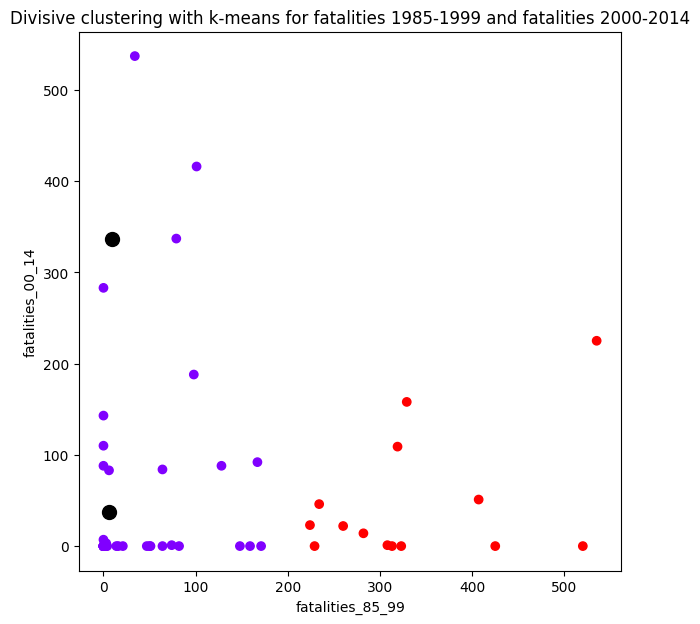

In [19]:
step = 'Step 2a'
n_clusters = 2
cluster_type = 'Divisive K-Means'
features_era = 'all'
features = get_feat(features_era)
cluster_col = f'cluster_d_{n_clusters}_all'
print(f"{step}: {n_clusters} Cluster {cluster_type} Cluster with incidents/fatalities from 1985-1989")
print(cluster_col)

X = df[features]
kmeans = KMeans(n_clusters=n_clusters)
y_means = kmeans.fit_predict(X)
inertia = kmeans.inertia_
print(f"Inertia (SSE) for KMeans: {inertia}")
k_silhouette = silhouette_score(X, y_means)
print(f"Silhouette Score for KMeans: {k_silhouette}")
centroids = kmeans.cluster_centers_
# Visualize the clusters
plt.figure(figsize=(7,7))
plt.title('Divisive clustering with k-means for fatalities 1985-1999 and fatalities 2000-2014')
plt.scatter(X['fatalities_85_99'], X['fatalities_00_14'], c=y_means, cmap='rainbow')
plt.scatter(centroids[:,0], centroids[:,2], c='black',s=100)
plt.xlabel('fatalities_85_99')
plt.ylabel('fatalities_00_14')
plt.show()
results[step] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 
                 'silhouette_score': float(k_silhouette), 'inertia': inertia, 'features_era': features_era, 'features': features}

Step 2a with Airline Labels
Inertia (SSE) for KMeans: 936115.9523809523
Silhouette Score for KMeans: 0.5694423760213854


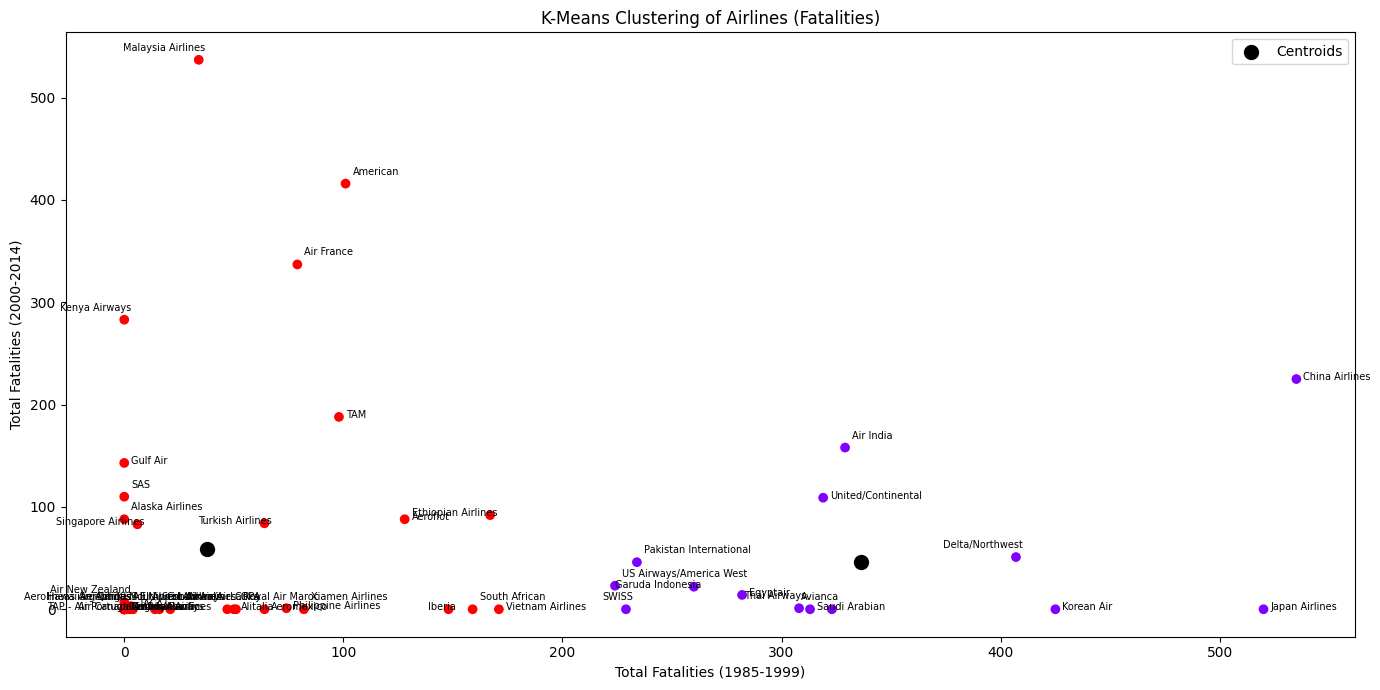

In [20]:
# Visualize the clusters with airline labels
step = 'Step 2a'
print(f"{step} with Airline Labels")
features_era = 'all'
features = get_feat(features_era)
X = df[features]
kmeans = KMeans(n_clusters=2, random_state=42)  # Added random_state for reproducibility
y_means = kmeans.fit_predict(X)
inertia = kmeans.inertia_
print(f"Inertia (SSE) for KMeans: {inertia}")
k_silhouette = silhouette_score(X, y_means)
print(f"Silhouette Score for KMeans: {k_silhouette}")
centroids = kmeans.cluster_centers_

# Visualize the clusters with airline labels
plt.figure(figsize=(14, 7))
plt.title('K-Means Clustering of Airlines (Fatalities)')
scatter = plt.scatter(X['fatalities_85_99'], X['fatalities_00_14'], c=y_means, cmap='rainbow')
plt.scatter(centroids[:, 2], centroids[:, 5], c='black', s=100, label='Centroids') # Corrected centroid indices
plt.xlabel('Total Fatalities (1985-1999)')
plt.ylabel('Total Fatalities (2000-2014)')
plt.legend()
# Add airline name labels to each point
for i, airline in enumerate(df['airline']):
    ha = 'right' if random.randint(1, 2) == 1 else 'left'
    va = 'top' if random.randint(1, 2) == 1 else 'bottom'
    plt.annotate(airline, (X['fatalities_85_99'].iloc[i], X['fatalities_00_14'].iloc[i]),
                 textcoords="offset points", xytext=(5,5), ha=ha, va=va, fontsize=7)
plt.tight_layout()
plt.show()

Step 2b Elbow Method: Calculate inertia for different numbers of clusters


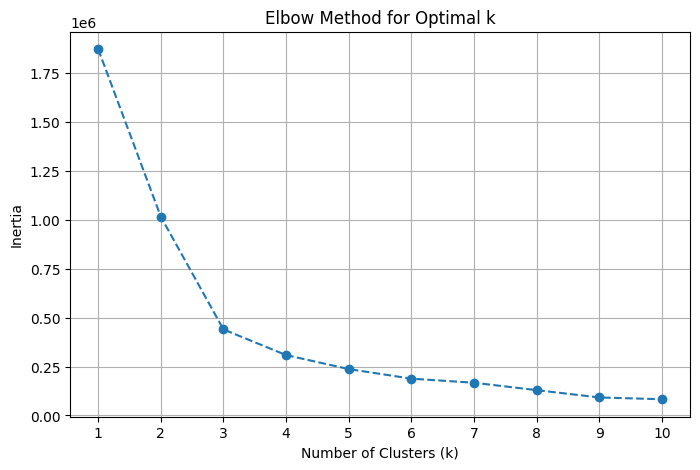

In [21]:
step = 'Step 2b'
print(f"{step} Elbow Method: Calculate inertia for different numbers of clusters")
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

In [22]:
step = 'Step 2c'
cluster_type = 'Divisive K-Means'
for features_era in features_eras:  # Convert range to list for consistency
    for n_clusters in [2, 3, 4, 5]:
        features = get_feat(features_era)
        cluster_col = f'cluster_d_{n_clusters}_{features_era}'
        print(f"{step}: {n_clusters} Cluster {cluster_type} Cluster with {features}")
        print(cluster_col)

        X = df[features]
        kmeans = KMeans(n_clusters=n_clusters)
        y_means = kmeans.fit_predict(X)
        inertia = kmeans.inertia_
        print(f"Inertia (SSE) for KMeans: {inertia}")
        k_silhouette = silhouette_score(X, y_means)
        print(f"Silhouette Score for KMeans: {k_silhouette}")
        results[f'{step}-{cluster_col}'] = {'scale': scale, 'n_clusters': n_clusters, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 
                                            'silhouette_score': float(k_silhouette), 'inertia': inertia, 'features_era': features_era, 'features': features}

Step 2c: 2 Cluster Divisive K-Means Cluster with ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']
cluster_d_2_pre
Inertia (SSE) for KMeans: 254882.9761904762
Silhouette Score for KMeans: 0.7374806208801999
Step 2c: 3 Cluster Divisive K-Means Cluster with ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']
cluster_d_3_pre
Inertia (SSE) for KMeans: 126343.03759398498
Silhouette Score for KMeans: 0.7139345976538934
Step 2c: 4 Cluster Divisive K-Means Cluster with ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']
cluster_d_4_pre
Inertia (SSE) for KMeans: 97509.4006734007
Silhouette Score for KMeans: 0.6477842935112614
Step 2c: 5 Cluster Divisive K-Means Cluster with ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']
cluster_d_5_pre
Inertia (SSE) for KMeans: 38469.075529100526
Silhouette Score for KMeans: 0.6910098651391854
Step 2c: 2 Cluster Divisive K-Means Cluster with ['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14

In [23]:
silhouette_high = 0
inertia_low = 999999
for o in results.items():
    if o[0].startswith('Step 2'):
        print(o)
        if o[1]['silhouette_score'] > silhouette_high:
            silhouette_high = o[1]['silhouette_score']
        if o[1]['inertia'] < inertia_low:
            inertia_low = o[1]['inertia']
print(inertia_low, silhouette_high)
print('')
for o in results.items():
    k = o[0]
    k_silhouette_score = o[1]['silhouette_score']
    inertia = o[1]['inertia']
    if k.startswith('Step 2') and '_all' in k:
        print(k, inertia, k_silhouette_score)
        
print('')
for o in results.items():
    k = o[0]
    k_silhouette_score = o[1]['silhouette_score']
    inertia = o[1]['inertia']
    if k.startswith('Step 2') and '_all' not in k:
        print(k, inertia, k_silhouette_score)

('Step 2a', {'scale': 'raw', 'n_clusters': 2, 'cluster_type': 'Divisive K-Means', 'cluster_col': 'cluster_d_2_all', 'silhouette_score': 0.5694423760213854, 'inertia': 936115.9523809523, 'features_era': 'all', 'features': ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99', 'incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']})
('Step 2c-cluster_d_2_pre', {'scale': 'raw', 'n_clusters': 2, 'cluster_type': 'Divisive K-Means', 'cluster_col': 'cluster_d_2_pre', 'silhouette_score': 0.7374806208801999, 'inertia': 254882.9761904762, 'features_era': 'pre', 'features': ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']})
('Step 2c-cluster_d_3_pre', {'scale': 'raw', 'n_clusters': 3, 'cluster_type': 'Divisive K-Means', 'cluster_col': 'cluster_d_3_pre', 'silhouette_score': 0.7139345976538934, 'inertia': 126343.03759398498, 'features_era': 'pre', 'features': ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']})
('Step 2c-cluster_d_4_pre', {'scale': '

## Step 2: Summary and Interpretation
a. Using the findings from Agglomerative in Step 1, decided to start with 2 clusters and look at what Divisive K-Means clusters would look like with all the data. The next cell shows the scatter plot with the Airline names plotting pre- and post-2000 fatalities, which nicely shows the worst and best airlines.<p>
b. Next, I did an elbow analysis to see what the appropriate k should be; there was not a definitive number so I tried 2-5 in the next step.<p>
c. Then I iterated using 2-5 clusters with pre- post-2000 and all features. As with Agglomerative, the pre- and post- clustering worked better, with lower inertia and higher Sillouette scores.<p>  
Based on these results for Dvisive, I would choose a Cluster of 2 using the pre-2000 or post- data.<p>
    
f. Finally, I compared the fatalities pre and post 2000 to answer the question "Should travelers avoid airlines that have had crashes in the past?". As expected, many, but not all, of the top 5 worst airlines for safety improved their records if they were in the "worst" pre-2000. However, China Airlines sadly got "worse" in that they still ended up in the top 5 worst post-2000 (noting that all airlines had fewer fatalities comparing pre- and post-2000).

# Accounting for size of airline
Since we are given a metric that lets us compare relative numbers of fatalities, I decided to use that with the best models from both steps above `avail_seat_km_per_week`.<p>
<b>These results should be scruitinized because we don't know when the `avail_seat_km_per_week` metric is from. Is it from the year 2000? An average? Something else?</b>

In [24]:
scale = 'km'
print("Convert to Available seats per 100M KM per week")
df_km = df_airline.copy()
for col in features_all:
    df_km[col] = df_airline[col] / df_airline['avail_seat_km_per_week'] * 100000000
df_km['airline'] = df_km['airline'].str.replace('*', '', regex=False)
df_km['airline'] = df_km['airline'].str.replace(' / ', '/', regex=False)
df_km.set_index('airline')
display(df_km.head(3))

Convert to Available seats per 100M KM per week


,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,0.623234,0.000000,0.000000,0.000000,0.000000,0.000000
1,Aeroflot,1197672318,6.345642,1.168934,10.687397,0.500972,0.083495,7.347586
2,Aerolineas Argentinas,385803648,1.555195,0.000000,0.000000,0.259199,0.000000,0.000000


In [25]:
print("Cluster with the scaled data")
step = 'Step 3'
for cluster_type in cluster_types:
    for features_era in features_eras:
        for n_clusters in [2, 3, 4, 5]:
            i += 1
            features = get_feat(features_era)
            X = df[features]
            step_key = f'{step}-{cluster_type}-{features_era}-{n_clusters}'
            if cluster_type == 'Agglomerative':
                cluster = AgglomerativeClustering(n_clusters=n_clusters)
                y_fit = ac.fit_predict(X)
                df[cluster_col] = y_ac
                inertia = None
            elif cluster_type == 'Divisive K-Means':
                cluster = KMeans(n_clusters=n_clusters)
                y_fit = kmeans.fit_predict(X)
                inertia = kmeans.inertia_
            
            s_silhouette_score = silhouette_score(X, y_fit)                
            results[step_key] = {'scale': scale, 'cluster_type': cluster_type, 'cluster_col': cluster_col, 'n_clusters': n_clusters, 
                                    'silhouette_score': float(s_silhouette_score), 'inertia': inertia, 'features_era': features_era, 'features': features}   

Cluster with the scaled data


In [26]:
# Setup colors and prep data for plotting
np.random.seed(42)  # optional: makes colors consistent on each run
color_map, labels = {}, []
for o in results.items():
    scale = o[1]['scale']
    cluster_type = o[1]['cluster_type']
    clus_short = 'Aggl' if 'Agg' in cluster_type else 'KMs'
    features_era = o[1]['features_era']
    key_str = f'{scale}-{clus_short}-{features_era}'
    if key_str not in color_map:
        color_map[key_str] = np.random.rand(4)     
        labels.append(key_str)

data_dict = {}
data = []
for o in results.items():
    scale = o[1]['scale']
    cluster_type = o[1]['cluster_type']
    clus_short = 'Aggl' if 'Agg' in cluster_type else 'KMs'
    n_clusters = o[1]['n_clusters']
    features_era = o[1]['features_era']
    silhouette_score = o[1]['silhouette_score']
    key = (scale, cluster_type, features_era)
    key_str = f'{scale}-{clus_short}-{features_era}'
    if key not in data_dict:
        data_dict[key] = []
    data_dict[key].append([n_clusters, silhouette_score])
    data.append([key_str, n_clusters, silhouette_score, color_map[key_str]])
print(data[:2])
color_map

[['raw-Aggl-pre', 5, 0.6989808140014081, array([0.37454012, 0.95071431, 0.73199394, 0.59865848])], ['raw-Aggl-pre', 2, 0.7374806208801999, array([0.37454012, 0.95071431, 0.73199394, 0.59865848])]]


{'raw-Aggl-pre': array([0.37454012, 0.95071431, 0.73199394, 0.59865848]),
 'raw-Aggl-all': array([0.15601864, 0.15599452, 0.05808361, 0.86617615]),
 'raw-Aggl-post': array([0.60111501, 0.70807258, 0.02058449, 0.96990985]),
 'raw-KMs-all': array([0.83244264, 0.21233911, 0.18182497, 0.18340451]),
 'raw-KMs-pre': array([0.30424224, 0.52475643, 0.43194502, 0.29122914]),
 'raw-KMs-post': array([0.61185289, 0.13949386, 0.29214465, 0.36636184]),
 'km-Aggl-pre': array([0.45606998, 0.78517596, 0.19967378, 0.51423444]),
 'km-Aggl-post': array([0.59241457, 0.04645041, 0.60754485, 0.17052412]),
 'km-Aggl-all': array([0.06505159, 0.94888554, 0.96563203, 0.80839735]),
 'km-KMs-pre': array([0.30461377, 0.09767211, 0.68423303, 0.44015249]),
 'km-KMs-post': array([0.12203823, 0.49517691, 0.03438852, 0.9093204 ]),
 'km-KMs-all': array([0.25877998, 0.66252228, 0.31171108, 0.52006802])}

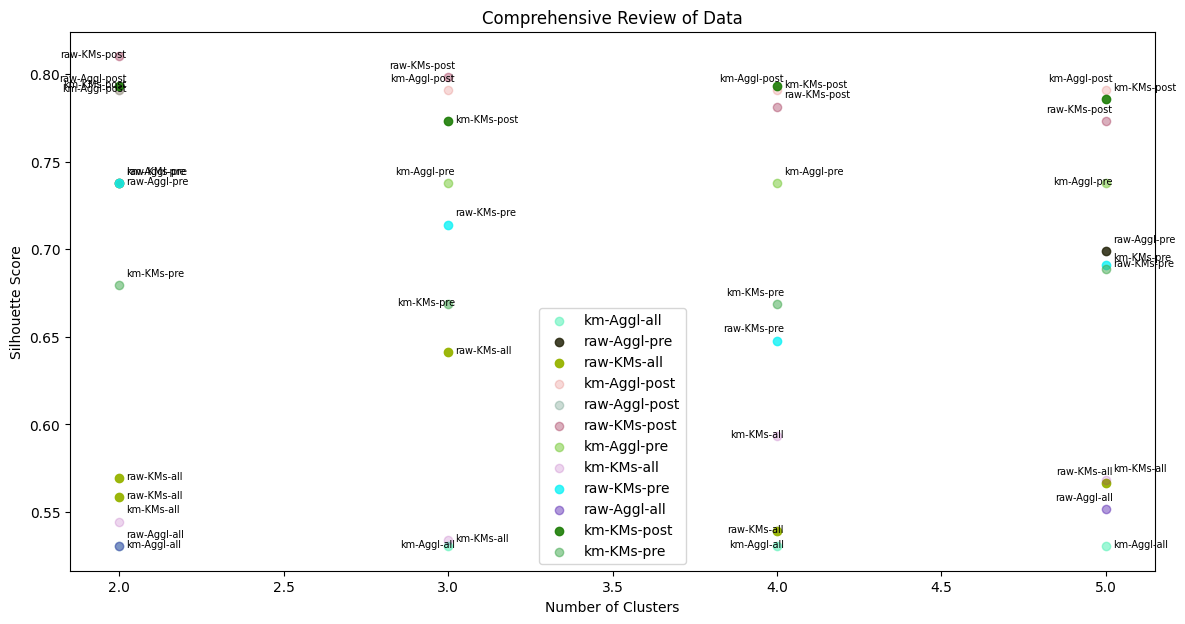

In [27]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Your unique labels and colors
labels = list(set(r[0] for r in data))
np.random.seed(42)
label_colors = {label: np.random.rand(4) for label in labels}

plt.figure(figsize=(14, 7))
plt.title('Comprehensive Review of Data')

# Group and plot by label
for label in labels:
    group = [r for r in data if r[0] == label]
    X = [r[1] for r in group]
    y = [r[2] for r in group]
    plt.scatter(X, y, c=[label_colors[label]], label=label)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()

# Add annotations (if you want)
for r in data:
    label = r[0]
    ha = 'right' if random.randint(1, 2) == 1 else 'left'
    va = 'top' if random.randint(1, 2) == 1 else 'bottom'
    plt.annotate(label, (r[1], r[2]), textcoords="offset points", xytext=(5,5), ha=ha, va=va, fontsize=7)

plt.show()

Account for size of airline does not produce better results, so I would stick with the results from the raw numbers. After all, most passengers are going to care more about raw numbers than percentages.<p>
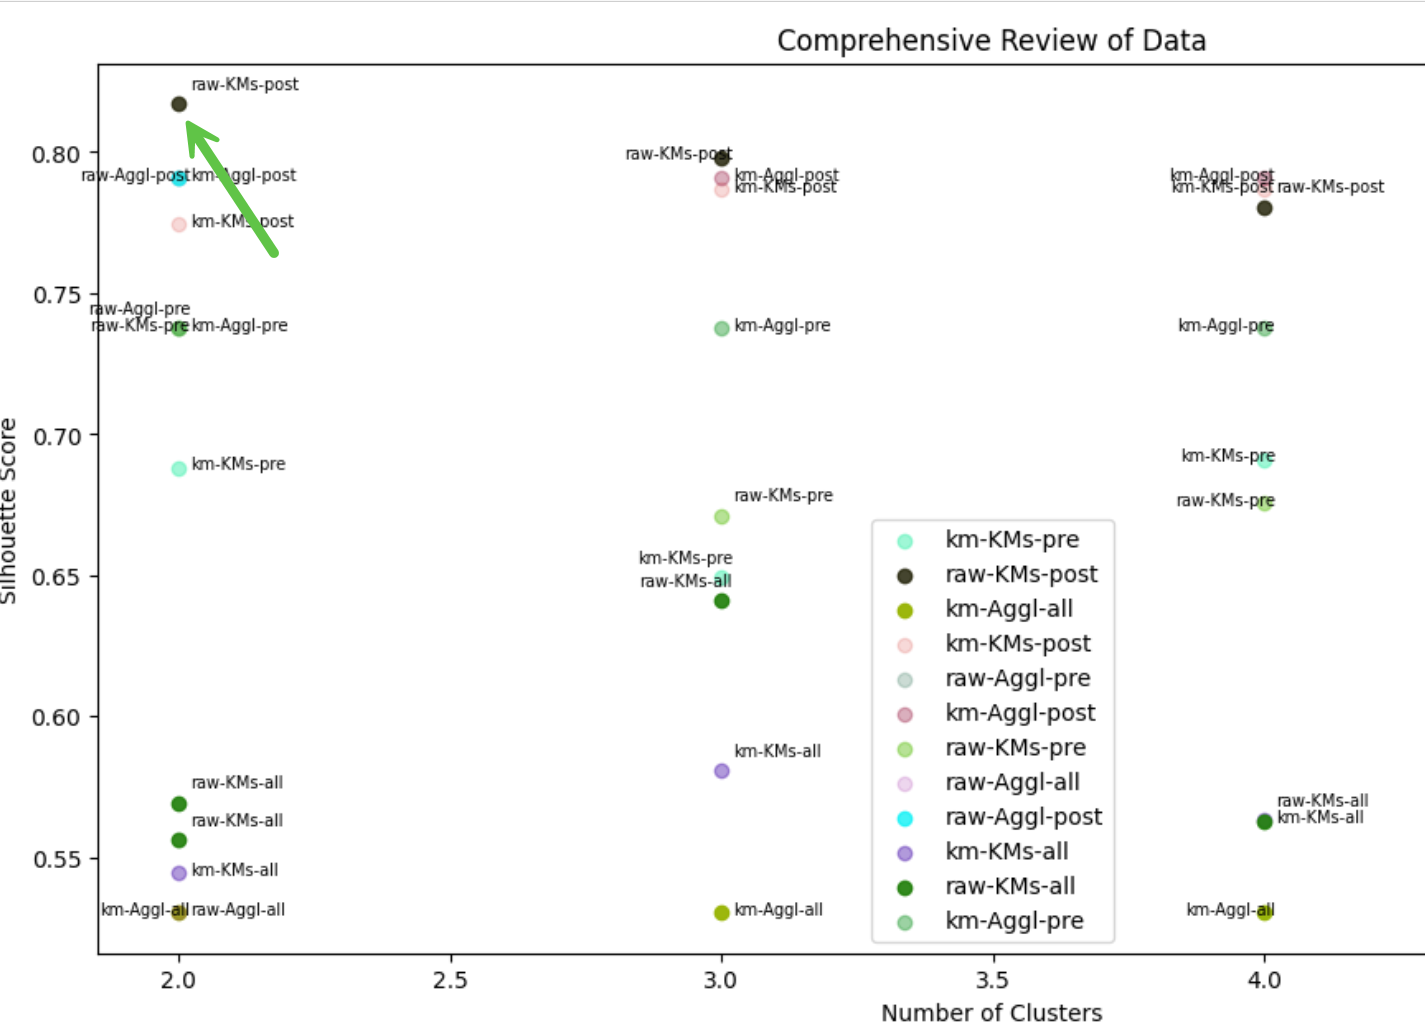

# Scaling Features; both Agglomerative and Divisive Clustering

Elbow Method for Agglomerative Clustering evaluating silhouette_score


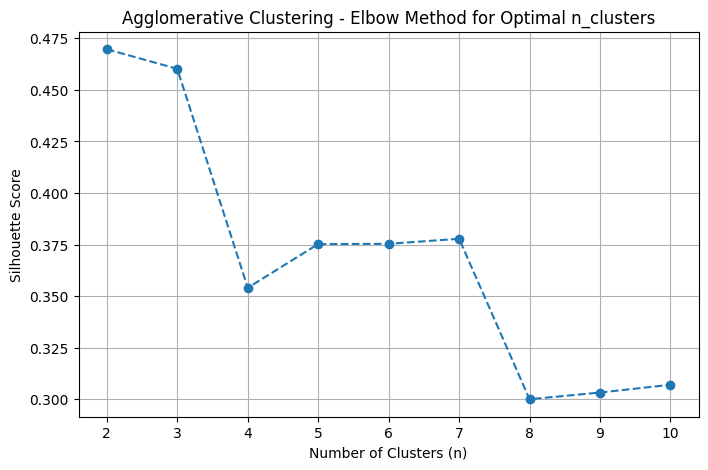

Elbow Method for K-Means Clustering evaluating silhouette_score


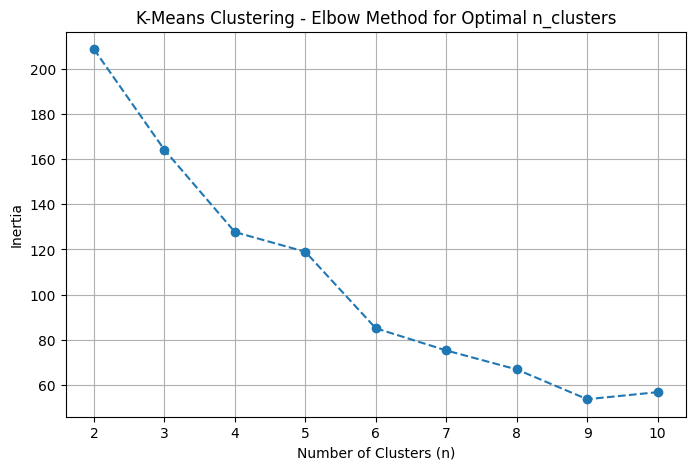

In [16]:
# Use the Elbow method to get the proper number of clusters
step = 'Step 1-Elbow'
features_era = 'all'
features = get_feat(features_era)
n_clusters = range(2, 11)

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Elbow Method for Agglomerative Clustering evaluating silhouette_score")
a_silhouettes = []
for n in n_clusters:
    ac = AgglomerativeClustering(n_clusters=n)
    y_ac = ac.fit_predict(X_scaled)
    a_silhouette = silhouette_score(X_scaled, y_ac)
    a_silhouettes.append(float(a_silhouette))
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(n_clusters, a_silhouettes, marker='o', linestyle='--')
plt.title('Agglomerative Clustering - Elbow Method for Optimal n_clusters')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters)
plt.grid()
plt.show()
    
inertias = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_scaled)
    inertias.append(float(kmeans.inertia_))
print(f"Elbow Method for K-Means Clustering evaluating silhouette_score")
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(n_clusters, inertias, marker='o', linestyle='--')
plt.title('K-Means Clustering - Elbow Method for Optimal n_clusters')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Inertia')
plt.xticks(n_clusters)
plt.grid()
plt.show()

### Best choice for number of clusters
Agglomerative → 2 clusters (best silhouette)<p>
K-Means → 4 clusters (clear elbow in inertia)

In [17]:
#### Best Models Scaled Features
step = 'Step 1-'
features_era = 'all'
features = get_feat(features_era)
n_clusters = range(2, 11)

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 2
ac = AgglomerativeClustering(n_clusters=n_clusters)
y_ac = ac.fit_predict(X_scaled)
a_silhouette = silhouette_score(X_scaled, y_ac)
print(f"Agglomerative Clustering with {n_clusters} clusters, Silhouette Score: {a_silhouette}; scaled features")

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_scaled)
y_ac = kmeans.fit_predict(X_scaled)
inertia = float(kmeans.inertia_)
k_silhouette = silhouette_score(X_scaled, y_ac)
print(f"K-Means Divisive Clustering with {n_clusters} clusters, Silhouette Score: {k_silhouette}, Inertia: {inertia}; scaled features")

Agglomerative Clustering with 2 clusters, Silhouette Score: 0.46971531601869554; scaled features
K-Means Divisive Clustering with 4 clusters, Silhouette Score: 0.41136202969867725, Inertia: 134.4743125571297; scaled features


After Scaling all the features and including them all, I determined n_clusters of 2 for Agglomerative and 4 for K-Means was best, but this only yielded Silhouette Scores:<p>
Agglomerative Clustering with 2 clusters, Silhouette Score: 0.47; scaled features<p>
K-Means Divisive Clustering with 4 clusters, Silhouette Score: 0.41, Inertia: 134; scaled features<p>